# GPT2 dummy architecture

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


In [2]:
import tiktoken
import torch

tokenizer = tiktoken.get_encoding('gpt2')

lines = [
    "Every effort moves you",
    "Every day holds a"    
]

batch = torch.stack([torch.tensor(tokenizer.encode(line)) for line in lines])

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [3]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg: dict[str, object]):
        super().__init__()

        # Embedding
        self.emb_layer = torch.nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_layer = torch.nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg["drop_rate"])

        # Transformer blocks
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Layer norms
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

        

    def forward(self, in_idx: torch.Tensor) -> torch.tensor:
        num_batches, seq_len = in_idx.shape
        embedding = self.emb_layer(in_idx)
        pos_embeddings = self.pos_layer(torch.arange(seq_len, device=in_idx.device))

        x = embedding + pos_embeddings
        x = self.dropout(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x


torch.manual_seed(123)
gpt_dummy = DummyGPTModel(GPT_CONFIG_124M)
logits = gpt_dummy(batch)

print(logits, logits.shape)

tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>) torch.Size([2, 4, 50257])


Kurzformel für LayerNorm (pro Sample über die Feature-Dimension)

Gegeben ein Vektor $x \in \mathbb{R}^H$:
- Mittelwert: $\mu = \frac{1}{H}\sum_{i=1}^{H} x_i$
- Varianz: $\sigma^2 = \frac{1}{H}\sum_{i=1}^{H} (x_i - \mu)^2$
- Normalisierung: $\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \varepsilon}}$
- Optionale affine Transformation: $y_i = \gamma_i \hat{x}_i + \beta_i$

Hinweis:
- Bei Tensoren mit Shape [Batch, …, Features] werden $\mu$ und $\sigma^2$ für jede Zeile/Position über die letzte Dimension (Features) berechnet.
- $\varepsilon$ ist eine kleine Konstante für Numerikstabilität; $\gamma,\beta \in \mathbb{R}^H$ sind lernbar.

In [4]:
t = torch.randn(2, 5)
mu = t.mean(dim=-1, keepdim=True)
var = t.var(dim=-1, keepdim=True, unbiased=False)
t_hat = (t - mu) / torch.sqrt(var + 1e-5)
gamma = nn.Parameter(torch.ones(5))
beta  = nn.Parameter(torch.zeros(5))
out = gamma * t_hat + beta

print(out)
print(out.mean(dim=-1, keepdim=True))
print(out.var(dim=-1, unbiased=False, keepdim=True))



tensor([[ 0.0455,  0.9326, -1.0036, -1.2364,  1.2619],
        [ 0.8868,  0.9411, -1.8051, -0.1976,  0.1748]], grad_fn=<AddBackward0>)
tensor([[ 0.0000e+00],
        [-2.3842e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim: int):
        super().__init__()
        self.eps = 1e-5                                   # Epsilon
        self.scale = nn.Parameter(torch.ones(emb_dim))    # Gamma
        self.shift = nn.Parameter(torch.zeros(emb_dim))   # Beta

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

ln = LayerNorm(emb_dim=5)
out_ln = ln(t)

print(out_ln)
print("Mean:\n",  out_ln.mean(dim=-1, keepdim=True))
print("Variance:\n", out_ln.var(dim=-1, unbiased=False, keepdim=True))



tensor([[ 0.0455,  0.9326, -1.0036, -1.2364,  1.2619],
        [ 0.8868,  0.9411, -1.8051, -0.1976,  0.1748]], grad_fn=<AddBackward0>)
Mean:
 tensor([[ 0.0000e+00],
        [-2.3842e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [6]:
import tinygrad
import tinygrad.nn


class TinyLayerNorm:
    def __init__(self, emb_dim: int):
        super().__init__()
        self.eps = 1e-5                                                    # Epsilon
        self.scale = tinygrad.Tensor.ones(emb_dim, requires_grad=True)     # Gamma
        self.shift = tinygrad.Tensor.zeros(emb_dim, requires_grad=True)    # Beta

    def forward(self, x:tinygrad.Tensor) -> tinygrad.Tensor:
        mean = x.mean(axis=-1, keepdim=True)
        var = x.var(axis=-1, keepdim=True,  correction=False)
        norm_x = (x - mean) / (var + self.eps).sqrt()
        return self.scale * norm_x + self.shift


class TinyGPTModel:
    def __init__(self, cfg: dict[str, object]):
        # Embedding
        self.emb_layer = tinygrad.nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_layer = tinygrad.nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_rate = cfg["drop_rate"]

        # Transformer blocks
        self.trf_blocks = [DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        
        # Layer norms
        self.final_norm = TinyLayerNorm(cfg["emb_dim"])
        self.out_head = tinygrad.nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)


    def forward(self, in_idx: tinygrad.Tensor) -> tinygrad.tensor:
        num_batches, seq_len = in_idx.shape
        embedding = self.emb_layer(in_idx)
        pos_embeddings = self.pos_layer(tinygrad.Tensor.arange(seq_len))

        x = embedding + pos_embeddings
        x = x.dropout(self.drop_rate)
        for block in self.trf_blocks:
            x = block(x)
        x = self.final_norm.forward(x)
        logits = self.out_head(x)
        return logits


tiny_batch = tinygrad.Tensor.stack([tinygrad.Tensor(tokenizer.encode(line)) for line in lines])

tinygrad.Tensor.manual_seed(42)
tiny = TinyGPTModel(GPT_CONFIG_124M)
logits = tiny.forward(tiny_batch)

print(logits.numpy(), logits.shape)

[[[-0.519526    0.7537327   0.2005472  ...  1.0668471  -1.5136696
   -0.33381417]
  [-0.34302607 -0.42789376 -0.25507692 ... -0.4442997  -0.13493417
    0.87539715]
  [-0.13321133  0.28134     0.40881827 ... -0.44780132 -0.11065756
    0.1352929 ]
  [ 0.10996917  1.0887383   0.5327068  ... -0.424065   -0.12587118
   -0.37713853]]

 [[-0.519526    0.7537327   0.2005472  ...  1.0668471  -1.5136696
   -0.33381417]
  [-0.02714658 -0.44134513 -0.16352235 ... -0.32524362 -0.22037949
    0.8112958 ]
  [-0.24537109  0.26612917  0.45883688 ... -0.4342     -0.00584923
   -0.17356916]
  [ 0.04278945  0.97872955  0.4680154  ... -0.31337032 -0.01501034
   -0.2654793 ]]] (2, 4, 50257)


# GELU activation

The GELU (Gaussian Error Linear Unit) approximation used in GPT-2 training is:

$$\text{GELU}(x) \approx 0.5x\left(1 + \tanh\left[\sqrt{\frac{2}{\pi}}\left(x + 0.044715x^3\right)\right]\right)$$

This is a computationally efficient approximation of the exact GELU function, which is defined as:

$$\text{GELU}(x) = x \cdot \Phi(x)$$

where $\Phi(x)$ is the cumulative distribution function of the standard normal distribution.

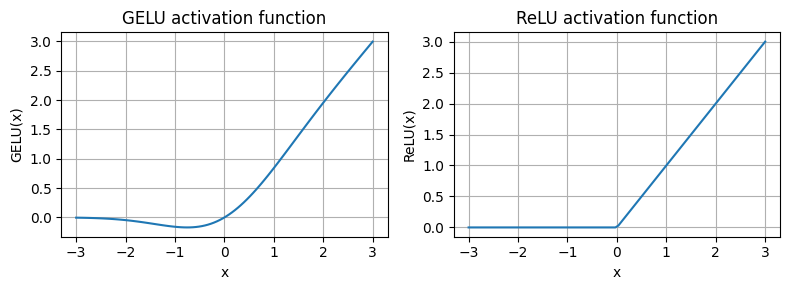

In [7]:
import matplotlib.pyplot as plt

class GELU(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = x + 0.044715 * x.pow(3)
        result = (2 / torch.pi) ** 0.5 * result
        result = 1 + result.tanh()
        result = 0.5 * x * result
        return result

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()



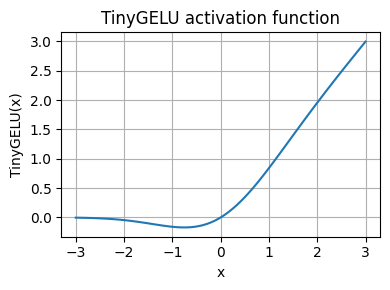

In [8]:
import math
import matplotlib.pyplot as plt
from tinygrad import Tensor


class TinyGELU:

    def __call__(self, x: Tensor) -> Tensor:
        result = x + 0.044715 * x.pow(3)
        result = (2 / math.pi) ** 0.5 * result
        result = 1 + result.tanh()
        result = 0.5 * x * result
        return result

gelu = TinyGELU()

def linspace(start, end, steps):
    return Tensor.arange(steps) * ((end - start) / (steps - 1)) + start

x = linspace(-3, 3, 100)
y_gelu = gelu(x)

plt.figure(figsize=(4, 3))
plt.title(f"TinyGELU activation function")
plt.xlabel("x")
plt.ylabel("TinyGELU(x)")
plt.grid(True)
plt.plot(x.numpy(), y_gelu.numpy())

plt.tight_layout()
plt.show()



In [9]:
import time

def a(x):
    # my version
    result = x + 0.044715 * x.pow(3)
    result = (2 / torch.pi) ** 0.5 * result
    result = 1 + result.tanh()
    result = 0.5 * x * result
    return result

def b(x):
    # reference implementation
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [10]:
x = torch.linspace(-3, 3, 100)

print(a(x))
print(b(x))

assert torch.allclose(a(x), b(x))  # they should be "equal" (despite some rounding errors)


start = time.time()
for i in range(100_000): a(x)
end = time.time()
print(f'a took {end - start:.2f}s')

start = time.time()
for i in range(100_000): b(x)
end = time.time()
print(f'b took {end - start:.2f}s')


tensor([-0.0036, -0.0044, -0.0053, -0.0063, -0.0076, -0.0090, -0.0106, -0.0124,
        -0.0145, -0.0169, -0.0196, -0.0225, -0.0259, -0.0295, -0.0336, -0.0380,
        -0.0428, -0.0481, -0.0537, -0.0597, -0.0660, -0.0728, -0.0798, -0.0871,
        -0.0947, -0.1024, -0.1102, -0.1180, -0.1257, -0.1332, -0.1404, -0.1472,
        -0.1534, -0.1588, -0.1634, -0.1669, -0.1691, -0.1700, -0.1694, -0.1669,
        -0.1626, -0.1562, -0.1476, -0.1366, -0.1232, -0.1071, -0.0882, -0.0666,
        -0.0422, -0.0148,  0.0155,  0.0487,  0.0849,  0.1239,  0.1657,  0.2102,
         0.2573,  0.3069,  0.3589,  0.4131,  0.4694,  0.5276,  0.5875,  0.6490,
         0.7119,  0.7760,  0.8412,  0.9072,  0.9740,  1.0414,  1.1092,  1.1773,
         1.2457,  1.3141,  1.3825,  1.4508,  1.5189,  1.5869,  1.6545,  1.7218,
         1.7888,  1.8554,  1.9216,  1.9875,  2.0529,  2.1179,  2.1826,  2.2469,
         2.3108,  2.3744,  2.4377,  2.5006,  2.5633,  2.6258,  2.6880,  2.7500,
         2.8118,  2.8735,  2.9350,  2.99

# Feed Forward Layer

1. **Expansion**: `emb_dim → 4 × emb_dim` (768 → 3072)
2. **Activation**: GELU
3. **Projection (reduction)**: `4 × emb_dim → emb_dim` (3072 → 768)

**Wichtige Eigenschaften:**

- **Input/Output gleiche Dimension**: `(batch_size, num_tokens, emb_dim)` bleibt erhalten
- **Faktor 4**: Die Zwischenschicht ist 4× größer (Standard in GPT-2)
- **Element-weise**: Jeder Token wird unabhängig verarbeitet
- **Keine Token-Interaktion**: Anders als bei Attention kommunizieren die Tokens hier nicht miteinander

In [11]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        emb_dim = cfg["emb_dim"]
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),    # Expansion
            GELU(),                             # Activation
            nn.Linear(4 * emb_dim, emb_dim),    # Projection (reduction)
        )

    def forward(self, x):
        return self.layers(x)


ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Shortcut Connections

Goal: prevent the *vanishing gradient problem*.

- no shortcuts: $y = F(x; W)$ with weights \(W\)
- with shortcuts: $y = F(x; W) + x$ ($x$ is added to the output)

<details>
    <summary>Explanation by GPT 5.1</summary>

## 1. Was ist ein Residual Block?

Ein typischer Residual Block macht:

- Eingabe: `x`
- „normales“ Layer (z.B. Linear + GELU): `F(x)`
- Ausgabe:  
  `y = x + F(x)`

In Code ungefähr so:

```python
layer_output = F(x)   # z.B. Linear + GELU
y = x + layer_output
```

Im **Rechen-Graphen** hast du zwei Pfade:

- langer Pfad: `x → F → y`
- kurzer Pfad (Shortcut): `x → y` (Identität, nur Addition)

Im **Forward-Pass** wird natürlich **beides** berechnet:
- du berechnest `F(x)`
- und du addierst `x + F(x)`

Es wird also kein Rechenschritt ausgelassen.

## 2. Woher kommt jetzt der „direkte Weg von y zu x“?

Der „direkte Weg“ meint den **Gradientenfluss im Backward-Pass**, also:

- Du hast einen Loss `L(y)`
- Du willst `∂L/∂x` ausrechnen

Wir haben:
- $y = x + F(x)$

Dann nach der Kettenregel:

$$
\frac{\partial L}{\partial x}
= \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x}
= \frac{\partial L}{\partial y} \cdot \left( I + \frac{\partial F(x)}{\partial x} \right)
$$

Ausgeschrieben (konzeptionell):

$$
\frac{\partial L}{\partial x}
= \underbrace{\frac{\partial L}{\partial y}}_{\text{direkter/Shortcut-Anteil}}
+ \underbrace{\frac{\partial L}{\partial y} \cdot \frac{\partial F(x)}{\partial x}}_{\text{normaler Layer-Anteil}}
$$

Das heißt: Der Gradient von `L` nach `x` besteht aus **zwei Teilen**:

1. Ein Teil läuft über `F` (normaler Weg durchs Layer).
2. Ein Teil kommt **direkt** von `y` zu `x` (über die Identität).

Dieser zweite Teil ist das, was man mit „direkter Pfad“ oder „von y zu x ohne durch das Layer zu gehen“ meint:  
Er enthält **keine Multiplikation mit Gewichten oder Aktivierungsableitungen** – nur die Identität.

## 3. Mini-Beispiel mit Skalar

Nimm ein ganz einfaches Beispiel:

- Skalar $x \in \mathbb{R}$
- Sei $F(x) = 2x$
- Residual Block: $y = x + F(x) = x + 2x = 3x$
- Loss: $L = \frac{1}{2} y^2$

Dann:

- $\frac{\partial L}{\partial y} = y$
- $\frac{\partial y}{\partial x} = 1 + \frac{\partial F}{\partial x} = 1 + 2 = 3$
- Also: \( \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot 3$

Wenn du die Zerlegung anschaust:

$$
\frac{\partial L}{\partial x}
= \frac{\partial L}{\partial y} \cdot 1
+ \frac{\partial L}{\partial y} \cdot \frac{\partial F}{\partial x}
= \underbrace{\frac{\partial L}{\partial y}}_{\text{direkter Shortcut}}
+ \underbrace{\frac{\partial L}{\partial y} \cdot 2}_{\text{durch F}}
$$

Beide Anteile addieren sich. Der Anteil `*1` kommt vom Weg `x → y` (Identität), der andere vom Weg `x → F → y`.

## 4. Intuition: Warum hilft das?

Ohne Residual:

- Tiefes Netz:  
  $x \to F_1 \to F_2 \to \dots \to F_n \to y$
- Gradient muss durch viele Ketten von Ableitungen, die oft < 1 sind ⇒ **Vanishing Gradients**.

Mit Residual-Blöcken, z.B.:

- $y_k = x_k + F_k(x_k)$
- $x_{k+1} = y_k$

bekommst du für jeden Block:

$$
\frac{\partial L}{\partial x_k}
= \frac{\partial L}{\partial x_{k+1}} \cdot \left( I + \frac{\partial F_k}{\partial x_k} \right)
$$

Da ist immer der Identitätsanteil `I` drin.  
Selbst wenn `∂F_k/∂x_k` klein wird, bleibt dieser **direkte Anteil** erhalten, und der Gradient „verpufft“ nicht so leicht.

## 5. Antwort auf deine Frage in einem Satz

- Im **Forward-Pass** gehst du immer durch das Layer `F` – es wird nicht „übersprungen“.
- Im **Backward-Pass** teilt sich der Gradient auf zwei Wege auf:
  - ein Weg durch `F` (normal),
  - und ein direkter Weg über die Identität (Shortcut), der nicht durch die komplizierten Transformationen geht.

Dieser direkte Anteil im Gradientenfluss ist das, was man meint, wenn man sagt:  
„Der Gradient kann von `y` zu `x` kommen, ohne durch das Layer zu gehen.“
</details>


In [12]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output  # F(x) + x
            else:
                x = layer_output  # F(x)
        return x

In [13]:
torch.manual_seed(123)

# Create the neural network
layer_sizes = [3, 3, 3, 3, 3, 3]  
dnn = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

x = torch.tensor([[1., 0., -1.]])
target = torch.tensor([[1., 1., 1.]])

# Forward
output = dnn(x)
print('Output:', output)

loss = nn.MSELoss()(output, target)
loss.backward()
print('Loss:', loss)

for name, param in filter(lambda x: 'weight' in x[0], dnn.named_parameters()):
    print(name, param.grad.abs().mean())

Output: tensor([[ 0.3280,  0.0256, -0.1513]], grad_fn=<MulBackward0>)
Loss: tensor(0.9088, grad_fn=<MseLossBackward0>)
layers.0.0.weight tensor(0.0011)
layers.1.0.weight tensor(0.0007)
layers.2.0.weight tensor(0.0049)
layers.3.0.weight tensor(0.0088)
layers.4.0.weight tensor(0.0198)


In [14]:
x = torch.tensor([[1., 0., -1.]])
target = torch.tensor([[1., 1., 1.]])

# Forward
dnn.use_shortcut = True
output = dnn(x)
print('Output:', output)

loss = nn.MSELoss()(output, target)
loss.backward()
print('Loss:', loss)

for name, param in filter(lambda x: 'weight' in x[0], dnn.named_parameters()):
    print(name, param.grad.abs().mean())

Output: tensor([[ 2.2153,  1.1165, -0.5633]], grad_fn=<AddBackward0>)
Loss: tensor(1.3115, grad_fn=<MseLossBackward0>)
layers.0.0.weight tensor(0.3433)
layers.1.0.weight tensor(0.2262)
layers.2.0.weight tensor(0.3800)
layers.3.0.weight tensor(0.4138)
layers.4.0.weight tensor(0.2993)
